In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

In [2]:
X

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [3]:
y

,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [4]:
y['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
class Fisher:
    def __init__(self, category=[1, 2]):
        self.class1 = category[0]
        self.class2 = category[1]
    def calculate_mean(self, X, y, category='R'):
        data = pd.concat([X, y], axis=1)
        return data[data['class'] == category].drop('class', axis=1).mean().values.reshape((1, -1))
    def calculate_S(self, X, y, category='R'):
        mu = self.calculate_mean(X, y, category)
        data = pd.concat([X, y], axis=1)
        data = data[data['class'] == category].drop('class', axis=1)
        data = data - mu
        return data.T.dot(data)
    def calculate_y_mean(self, X, y, w, category='R'):
        data = pd.concat([X, y], axis=1)
        data = data[data['class'] == category].drop('class', axis=1)
        return float(w.T.dot(data.T).mean())
    def calculate_amount(self, X, y, category='R'):
        data = pd.concat([X, y], axis=1)
        data = data[data['class'] == category].drop('class', axis=1)
        return len(data)
    def fit(self, X, y):
        self.mu1 = self.calculate_mean(X, y, self.class1)
        self.mu2 = self.calculate_mean(X, y, self.class2)
        self.S1 = self.calculate_S(X, y, self.class1)
        self.S2 = self.calculate_S(X, y, self.class2)
        self.Sw = self.S1 + self.S2
        self.w_star = np.linalg.inv(self.Sw).dot((self.mu1 - self.mu2).T)
        self.mu1_ba = self.calculate_y_mean(X, y, self.w_star, self.class1)
        self.mu2_ba = self.calculate_y_mean(X, y, self.w_star, self.class2)
        self.N1 = self.calculate_amount(X, y, self.class1)
        self.N2 = self.calculate_amount(X, y, self.class2)
    def predict(self, xx, method='平均'):
        if method == '平均':
            # 平均
            self.y0 = (self.mu1_ba + self.mu2_ba) / 2
        else:
            # 加权平均
            self.y0 = (self.N1 * self.mu1_ba + self.N2 * self.mu2_ba) / (self.N1 + self.N2)
        self.y_tmp = self.w_star.T.dot(xx.T)
        self.y_tmp = np.where(self.y_tmp >= self.y0, 1, 0)
        self.y_predict = np.empty(self.y_tmp.shape, dtype=object)
        self.y_predict[self.y_tmp == 1] = self.class1
        self.y_predict[self.y_tmp == 0] = self.class2
        self.y_predict = self.y_predict.reshape((-1, 1))
        return self.y_predict
    def accuracy(self, y_true):
        return int(np.sum(np.array(y_true) == self.y_predict)) / len(self.y_predict)

One-versus-one

In [6]:
class FisherMultiClass:
    def __init__(self, categories=[0, 1, 2]):
        self.categories = categories
        self.models = {}

    def fit(self, X, y):
        # 为每一对类别创建一个Fisher模型
        for i in range(len(self.categories)):
            for j in range(i + 1, len(self.categories)):
                category_pair = (self.categories[i], self.categories[j])
                model = Fisher(category=category_pair)
                model.fit(X, y)
                self.models[category_pair] = model

    def predict(self, xx):
        # 利用所有模型进行预测
        predictions = []
        for model in self.models.values():
            pred = model.predict(xx)
            predictions.append(pred)
        
        # 修改predictions形状,使得每一列为三个模型分别预测得到的一个样本的种类
        predictions = np.array(predictions).reshape(len(self.models), -1)
        final_predictions = []
        
        # 投票法确定最终类别
        for i in range(predictions.shape[1]):
            unique, counts = np.unique(predictions[:, i], return_counts=True)
            final_predictions.append(unique[np.argmax(counts)])
        self.y_predict = np.array(final_predictions).reshape((-1, 1))
        return self.y_predict

    def accuracy(self, y_true):
        return int(np.sum(np.array(y_true) == self.y_predict)) / len(self.y_predict)

5折交叉验证

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_with_dim = dict()
y_preds = dict()
for dim in range(1, X.shape[1]+1):
    XX = X.iloc[:, :dim]
    yy = y.copy()
    accuracies = []
    for train_index, test_index in kf.split(XX):
        X_train, X_test = XX.iloc[train_index], XX.iloc[test_index]
        y_train, y_test = yy.iloc[train_index], yy.iloc[test_index]
        model = FisherMultiClass(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_preds[dim] = y_pred
        accuracy = model.accuracy(y_test)
        accuracies.append(accuracy)
    mean_accuracy = float(np.mean(accuracies))
    print("dim = ", dim, " 平均准确率:", mean_accuracy)
    accuracy_with_dim[dim] = mean_accuracy

dim =  1  平均准确率: 0.7333333333333334
dim =  2  平均准确率: 0.8
dim =  3  平均准确率: 0.9466666666666667
dim =  4  平均准确率: 0.9733333333333334


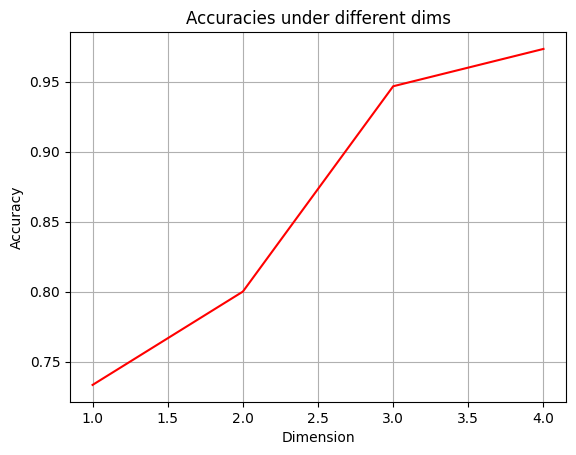

In [8]:
plt.plot(accuracy_with_dim.keys(), accuracy_with_dim.values(), color='r')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracies under different dims')
plt.grid()
plt.show()